In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
jf = full_results[full_results['candidate'] == 'Jennifer Gutierrez']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

In [2]:
demo_occ = jf[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [3]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [10]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop'] + wp_cols

In [5]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,log_mhhi21,venez21p,chin21p,kor21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,0.292757,-0.210158,-0.146247,-0.186318,0.458630,0.006761,-0.095609,-0.189138,0.345569,...,-0.307033,0.150295,0.154266,-0.223007,-0.085640,-0.135064,-0.180011,-0.056911,-0.351695,-0.136580
white_transplant_ratio,0.493810,0.744327,-0.371815,-0.639310,-0.052660,0.865822,0.368410,0.227004,-0.166215,0.464595,...,-0.518293,-0.098716,0.176167,-0.410937,-0.124886,-0.327877,-0.212658,-0.178654,-0.254686,-0.523173
cvap21bapp,0.458630,0.813896,-0.582051,-0.634217,0.118857,1.000000,0.371917,0.158496,-0.076177,0.478513,...,-0.466643,-0.053360,0.221926,-0.417984,-0.177993,-0.173016,-0.308393,-0.064807,-0.176148,-0.530833
w2banp,0.380968,0.594240,-0.445917,-0.508901,0.228155,0.658695,-0.004068,0.063665,0.153718,0.295252,...,-0.276023,0.047172,0.203157,-0.136556,-0.098733,-0.277765,-0.316289,-0.132841,-0.349526,-0.497524
w2cmp,0.372882,0.561837,-0.355212,-0.413855,-0.104928,0.660418,0.224013,0.127121,-0.176761,0.537175,...,-0.433082,0.006466,0.216579,-0.166966,-0.122940,-0.330638,-0.342544,-0.023862,-0.064952,-0.270190
kor21p,0.345569,0.267477,-0.355130,-0.105299,0.011292,0.478513,0.162270,0.026636,-0.103153,1.000000,...,-0.229997,-0.038581,0.255844,-0.143074,-0.080120,-0.203406,-0.126934,-0.000958,-0.150340,-0.085455
nhw21p,0.292757,1.000000,-0.543285,-0.843898,0.082619,0.813896,0.257470,0.074615,-0.052287,0.267477,...,-0.420850,-0.159903,0.106030,-0.373403,-0.154812,-0.257798,-0.294124,-0.105581,-0.244105,-0.535552
w2admp,0.210411,0.555886,-0.417707,-0.435725,0.111429,0.693403,0.412953,0.383381,-0.065183,0.378272,...,-0.151607,-0.199151,0.104363,-0.373199,-0.149988,-0.117425,-0.051858,0.064006,-0.061237,-0.519103
w2mgtp,0.173029,0.624288,-0.449125,-0.448609,-0.098741,0.597878,0.250432,0.131975,-0.280222,0.333711,...,-0.297893,-0.139697,0.354487,-0.484523,-0.073749,-0.313944,-0.078547,0.001031,-0.183742,-0.457375
fb21drp,0.162388,-0.319134,-0.084615,0.513860,-0.181993,-0.146934,-0.136349,-0.079387,-0.129201,0.146911,...,-0.075607,0.517307,0.189862,0.269836,-0.062811,0.157391,0.072355,0.130587,0.086635,0.162935


In [11]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.43688225 0.29244496 0.41817849 0.28821305 0.65638831 0.71353114
 0.17160945 0.42176592 0.32730026 0.56274391 0.46874884 0.22721151
 0.66647883 0.32299059 0.18905734 0.12155854 0.29738473 0.48514699
 0.09906627 0.22922307 0.34647986 0.2714468  0.63751911 0.49981388
 0.39375403 0.54011337 0.44706578 0.42765347 0.31426454 0.19986274
 0.62332782 0.28236489 0.16436866 0.49959893 0.28144384 0.14178168
 0.22647108 0.37261972 0.22111663 0.34025766 0.54695585 0.17859965
 0.33149898 0.25134338 0.34721923 0.23852257 0.43367126]
Overall KMO: 0.361818259963321
Bartlett’s test χ²: 6237.356244908575 p-value: 0.0


In [12]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [13]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'arab21p' (KMO=0.099); new overall KMO before recalculation = 0.362
Dropping 'pak21p' (KMO=0.134); new overall KMO before recalculation = 0.390
Dropping 'w2copp' (KMO=0.182); new overall KMO before recalculation = 0.408
Dropping 'bang21p' (KMO=0.183); new overall KMO before recalculation = 0.448
Dropping 'w2farmp' (KMO=0.254); new overall KMO before recalculation = 0.486
Dropping 'w2ffp' (KMO=0.257); new overall KMO before recalculation = 0.491
Dropping 'filip21p' (KMO=0.278); new overall KMO before recalculation = 0.539
Dropping 'hh21bop' (KMO=0.308); new overall KMO before recalculation = 0.557
Dropping 'venez21p' (KMO=0.259); new overall KMO before recalculation = 0.574
Dropping 'fb21bdp' (KMO=0.307); new overall KMO before recalculation = 0.597
Dropping 'w2tranp' (KMO=0.369); new overall KMO before recalculation = 0.602
Dropping 'w2scip' (KMO=0.402); new overall KMO before recalculation = 0.616
Dropping 'w2htp' (KMO=0.406); new overall KMO before recalculation = 0.622
Drop

In [14]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

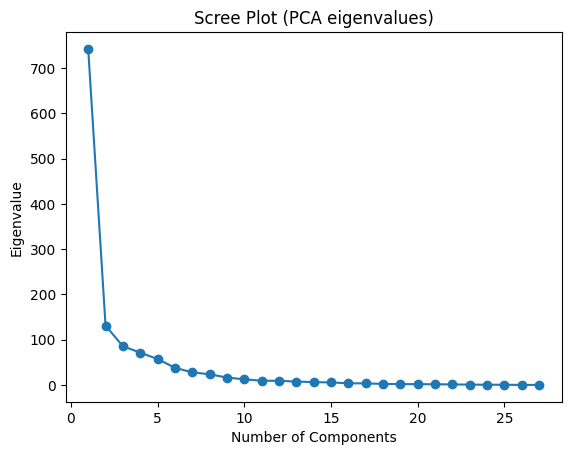

In [15]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [16]:
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [17]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [18]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1   Factor2   Factor3
nhw21p                  14.675503 -2.318305 -0.197503
h21p                   -13.241377 -0.335858 -4.669484
nha21p                   1.310403  5.208564 -0.943768
cvap21bapp              13.079696 -2.598206 -6.682998
log_mhhi21               0.246207 -0.301735 -0.212820
chin21p                  0.514058  4.966932 -0.054517
kor21p                   0.152617 -0.081170 -0.261788
domin21p                -2.959525 -0.613063 -1.575419
mex21p                  -2.128436 -1.060384 -1.871027
white_transplant_ratio   6.233018 -2.262654 -2.388532
greek21p                -0.105873 -0.098630  0.007272
fb21drp                 -1.489808 -0.492855 -1.444806
w2mgtp                   3.186735 -1.732072 -1.035533
w2banp                   2.384503  0.211272 -0.992579
w2cmp                    1.746508 -0.897669 -0.951553
w2aep                    0.464739  0.311670 -0.111959
w2cossp                 -0.603869  0.096567  0.633174
w2lawp    

In [19]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     13.03
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           2.19e-07
Time:                        14:49:24   Log-Likelihood:                -465.92
No. Observations:                 119   AIC:                             939.8
Df Residuals:                     115   BIC:                             951.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.8793      1.132     64.385      0.0

In [21]:
Y = demo_occ['vote_share']
model1 = sm.OLS(Y, sm.add_constant(demo_occ[['white_transplant_ratio','mex21p','domin21p','nhb21p']])).fit()
model2 = sm.OLS(Y, sm.add_constant(demo_occ[['white_transplant_ratio','mex21p','domin21p','nhb21p','w2cmp','w2admp','w2conp','w2foodp']])).fit()
summary_col([model1,model2],stars=True)

,vote_share I,vote_share II
const,53.1963***,56.3405***
,(4.3769),(5.6018)
white_transplant_ratio,0.9754***,1.1539***
,(0.1612),(0.2453)
mex21p,0.0263,0.2266
,(0.2122),(0.2621)
domin21p,0.5154**,0.4232*
,(0.2248),(0.2463)
nhb21p,-0.0431,-0.0344
,(0.1203),(0.1405)
